# 🔧 Preprocesamiento de Datos Tabulares Clínicos

**Objetivo:** Aplicar el pipeline completo de preprocesamiento a los datos clínicos del proyecto de Alzheimer. Alzheimers disease data.

---

## Pipeline de Preprocesamiento

1. **Carga de datos** desde CSV
2. **Verificación de valores faltantes**
3. **Imputación** (KNN o mediana)
4. **Encoding** de variables categóricas (One-Hot)
5. **Ingeniería de características**
6. **Escalamiento** (StandardScaler)
7. **Selección de características** (correlaciones, mutual information)
8. **Guardado de datos procesados**


In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuración de rutas
BASE_DIR = Path().resolve().parent
RAW_CLINICAL_DIR = BASE_DIR / "data" / "raw" / "clinical"
PROCESSED_DIR = BASE_DIR / "data" / "processed" / "tabular_clean"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"📁 Directorio base: {BASE_DIR}")
print(f"📁 Datos clínicos raw: {RAW_CLINICAL_DIR}")
print(f"📁 Directorio de salida: {PROCESSED_DIR}")


KeyboardInterrupt: 

## 1. Carga de Datos


In [ ]:
# Cargar datos clínicos
INPUT_PATH = RAW_CLINICAL_DIR / "alzheimers_disease_data.csv"
OUTPUT_PATH = PROCESSED_DIR / "clinical_data_cleaned.csv"

print(f"📁 Cargando datos desde: {INPUT_PATH}")
df = pd.read_csv(INPUT_PATH)
print(f"✓ Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"\nPrimeras filas:")
df.head()

# Eliminar columnas de identificación que no son útiles para el análisis
print("\n🗑️  Eliminando columnas de identificación...")
columns_to_drop = []
if 'PatientID' in df.columns:
    columns_to_drop.append('PatientID')
if 'DoctorInCharge' in df.columns:
    columns_to_drop.append('DoctorInCharge')

if columns_to_drop:
    df = df.drop(columns=columns_to_drop)
    print(f"✓ Columnas eliminadas: {columns_to_drop}")
    print(f"✓ Dimensiones después de eliminar columnas: {df.shape}")
else:
    print("✓ No se encontraron columnas de identificación para eliminar")


📁 Cargando datos desde: C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\raw\clinical\alzheimers_disease_data.csv
✓ Datos cargados: 2149 filas, 35 columnas

Primeras filas:


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [ ]:
# Información general del dataset
print("Información del dataset:")
print(f"  - Filas: {df.shape[0]}")
print(f"  - Columnas: {df.shape[1]}")
print(f"  - Tipos de datos:\n{df.dtypes.value_counts()}")
print(f"\nColumnas:\n{list(df.columns)}")


Información del dataset:
  - Filas: 2149
  - Columnas: 35
  - Tipos de datos:
int64      22
float64    12
object      1
Name: count, dtype: int64

Columnas:
['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness', 'Diagnosis', 'DoctorInCharge']


## 2. Verificación de Valores Faltantes


In [ ]:
# Verificar valores faltantes
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100

result = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percentage': missing_pct
})
result = result[result['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

if len(result) > 0:
    print("⚠️  Valores faltantes encontrados:")
    print(result)
else:
    print("✓ No se encontraron valores faltantes")


✓ No se encontraron valores faltantes


## 3. Imputación de Valores Faltantes


In [ ]:
# Configuración de imputación
IMPUTATION_METHOD = 'knn'  # 'knn' o 'median'
N_NEIGHBORS = 5

df_imputed = df.copy()
missing = df.isnull().sum()

if missing.sum() == 0:
    print("✓ No hay valores faltantes para imputar")
else:
    # Separar numéricas y categóricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Imputar numéricas
    numeric_missing = [col for col in numeric_cols if missing[col] > 0]
    if numeric_missing:
        print(f"\n🔄 Imputando {len(numeric_missing)} columnas numéricas usando {IMPUTATION_METHOD}...")
        if IMPUTATION_METHOD == 'knn':
            imputer = KNNImputer(n_neighbors=N_NEIGHBORS)
            df_imputed[numeric_cols] = imputer.fit_transform(df[numeric_cols])
        else:  # median
            imputer = SimpleImputer(strategy='median')
            df_imputed[numeric_cols] = imputer.fit_transform(df[numeric_cols])
        print("✓ Imputación numérica completada")
    
    # Imputar categóricas (moda)
    categorical_missing = [col for col in categorical_cols if missing[col] > 0]
    if categorical_missing:
        print(f"\n🔄 Imputando {len(categorical_missing)} columnas categóricas usando moda...")
        imputer = SimpleImputer(strategy='most_frequent')
        df_imputed[categorical_cols] = imputer.fit_transform(df[categorical_cols])
        print("✓ Imputación categórica completada")

df = df_imputed.copy()
print(f"\n✓ Datos después de imputación: {df.shape}")


✓ No hay valores faltantes para imputar

✓ Datos después de imputación: (2149, 35)


## 4. Encoding de Variables Categóricas


In [ ]:
# Detectar variables categóricas
DROP_FIRST = True  # Evita multicolinealidad
encoding_info = {}

# Detectar categóricas (object o int con pocos valores únicos)
categorical_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        categorical_cols.append(col)
    elif df[col].dtype in ['int64', 'int32']:
        unique_vals = df[col].nunique()
        if unique_vals <= 10:  # Considerar categórica si tiene <= 10 valores únicos
            categorical_cols.append(col)

# Filtrar solo las que realmente son categóricas (no binarias que ya están codificadas)
true_categorical = []
for col in categorical_cols:
    if df[col].dtype == 'object' or (df[col].nunique() > 2 and df[col].nunique() <= 10):
        true_categorical.append(col)

print(f"Variables categóricas detectadas: {true_categorical}")

if not true_categorical:
    print("✓ No hay variables categóricas que requieran encoding")
else:
    print(f"\n🔄 Aplicando One-Hot Encoding a {len(true_categorical)} variables categóricas...")
    
    for col in true_categorical:
        if df[col].dtype == 'object':
            # One-hot encoding
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=DROP_FIRST)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col])
            encoding_info[col] = {
                'method': 'one_hot',
                'new_columns': dummies.columns.tolist()
            }
            print(f"  ✓ {col}: {len(dummies.columns)} nuevas columnas")
    
    print(f"✓ Encoding completado. Nuevas dimensiones: {df.shape}")


Variables categóricas detectadas: ['Ethnicity', 'EducationLevel', 'DoctorInCharge']

🔄 Aplicando One-Hot Encoding a 3 variables categóricas...
  ✓ DoctorInCharge: 0 nuevas columnas
✓ Encoding completado. Nuevas dimensiones: (2149, 34)


## 5. Ingeniería de Características


In [ ]:
# Crear nuevas características
new_features = []

print("\n🔧 Creando características de ingeniería...")

# 1. Edad al cuadrado (relación no lineal con demencia)
if 'Age' in df.columns:
    df['Age_squared'] = df['Age'] ** 2
    new_features.append('Age_squared')
    print("  ✓ Age_squared creada")

# 2. Categorías de BMI
if 'BMI' in df.columns:
    df['BMI_category'] = pd.cut(
        df['BMI'],
        bins=[0, 18.5, 25, 30, np.inf],
        labels=[0, 1, 2, 3]  # Bajo peso, Normal, Sobrepeso, Obesidad
    ).astype(int)
    new_features.append('BMI_category')
    print("  ✓ BMI_category creada")

# 3. Presión arterial media (MAP - Mean Arterial Pressure)
if 'SystolicBP' in df.columns and 'DiastolicBP' in df.columns:
    df['MAP'] = (2 * df['DiastolicBP'] + df['SystolicBP']) / 3
    new_features.append('MAP')
    print("  ✓ MAP (Mean Arterial Pressure) creada")

# 4. Ratio Colesterol Total/HDL (indicador de riesgo cardiovascular)
if 'CholesterolTotal' in df.columns and 'CholesterolHDL' in df.columns:
    df['Cholesterol_ratio'] = df['CholesterolTotal'] / (df['CholesterolHDL'] + 1e-6)
    new_features.append('Cholesterol_ratio')
    print("  ✓ Cholesterol_ratio creada")

# 5. Comorbilidades combinadas (índice de carga de enfermedad)
comorbidity_cols = [
    'CardiovascularDisease', 'Diabetes', 'Depression', 
    'Hypertension', 'HeadInjury'
]
existing_comorb = [col for col in comorbidity_cols if col in df.columns]
if existing_comorb:
    df['Comorbidity_count'] = df[existing_comorb].sum(axis=1)
    new_features.append('Comorbidity_count')
    print("  ✓ Comorbidity_count creada")

# 6. Síntomas cognitivos combinados
cognitive_symptoms = [
    'MemoryComplaints', 'Confusion', 'Disorientation',
    'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness'
]
existing_symptoms = [col for col in cognitive_symptoms if col in df.columns]
if existing_symptoms:
    df['Cognitive_symptoms_count'] = df[existing_symptoms].sum(axis=1)
    new_features.append('Cognitive_symptoms_count')
    print("  ✓ Cognitive_symptoms_count creada")

# 7. Interacción: Edad × MMSE (deterioro cognitivo ajustado por edad)
if 'Age' in df.columns and 'MMSE' in df.columns:
    df['Age_MMSE_interaction'] = df['Age'] * df['MMSE']
    new_features.append('Age_MMSE_interaction')
    print("  ✓ Age_MMSE_interaction creada")

# 8. Riesgo cardiovascular combinado
if 'Hypertension' in df.columns and 'CardiovascularDisease' in df.columns:
    df['Cardiovascular_risk'] = (
        df['Hypertension'].astype(int) + 
        df['CardiovascularDisease'].astype(int)
    )
    new_features.append('Cardiovascular_risk')
    print("  ✓ Cardiovascular_risk creada")

print(f"\n✓ Ingeniería de características completada. {len(new_features)} nuevas características creadas")
print(f"  Nuevas características: {new_features}")
print(f"  Dimensiones: {df.shape}")



🔧 Creando características de ingeniería...
  ✓ Age_squared creada
  ✓ BMI_category creada
  ✓ MAP (Mean Arterial Pressure) creada
  ✓ Cholesterol_ratio creada
  ✓ Comorbidity_count creada
  ✓ Cognitive_symptoms_count creada
  ✓ Age_MMSE_interaction creada
  ✓ Cardiovascular_risk creada

✓ Ingeniería de características completada. 8 nuevas características creadas
  Nuevas características: ['Age_squared', 'BMI_category', 'MAP', 'Cholesterol_ratio', 'Comorbidity_count', 'Cognitive_symptoms_count', 'Age_MMSE_interaction', 'Cardiovascular_risk']
  Dimensiones: (2149, 42)


## 5.5. Análisis de Distribuciones y Detección de Outliers


📊 Generando histogramas de distribución para todas las características numéricas...


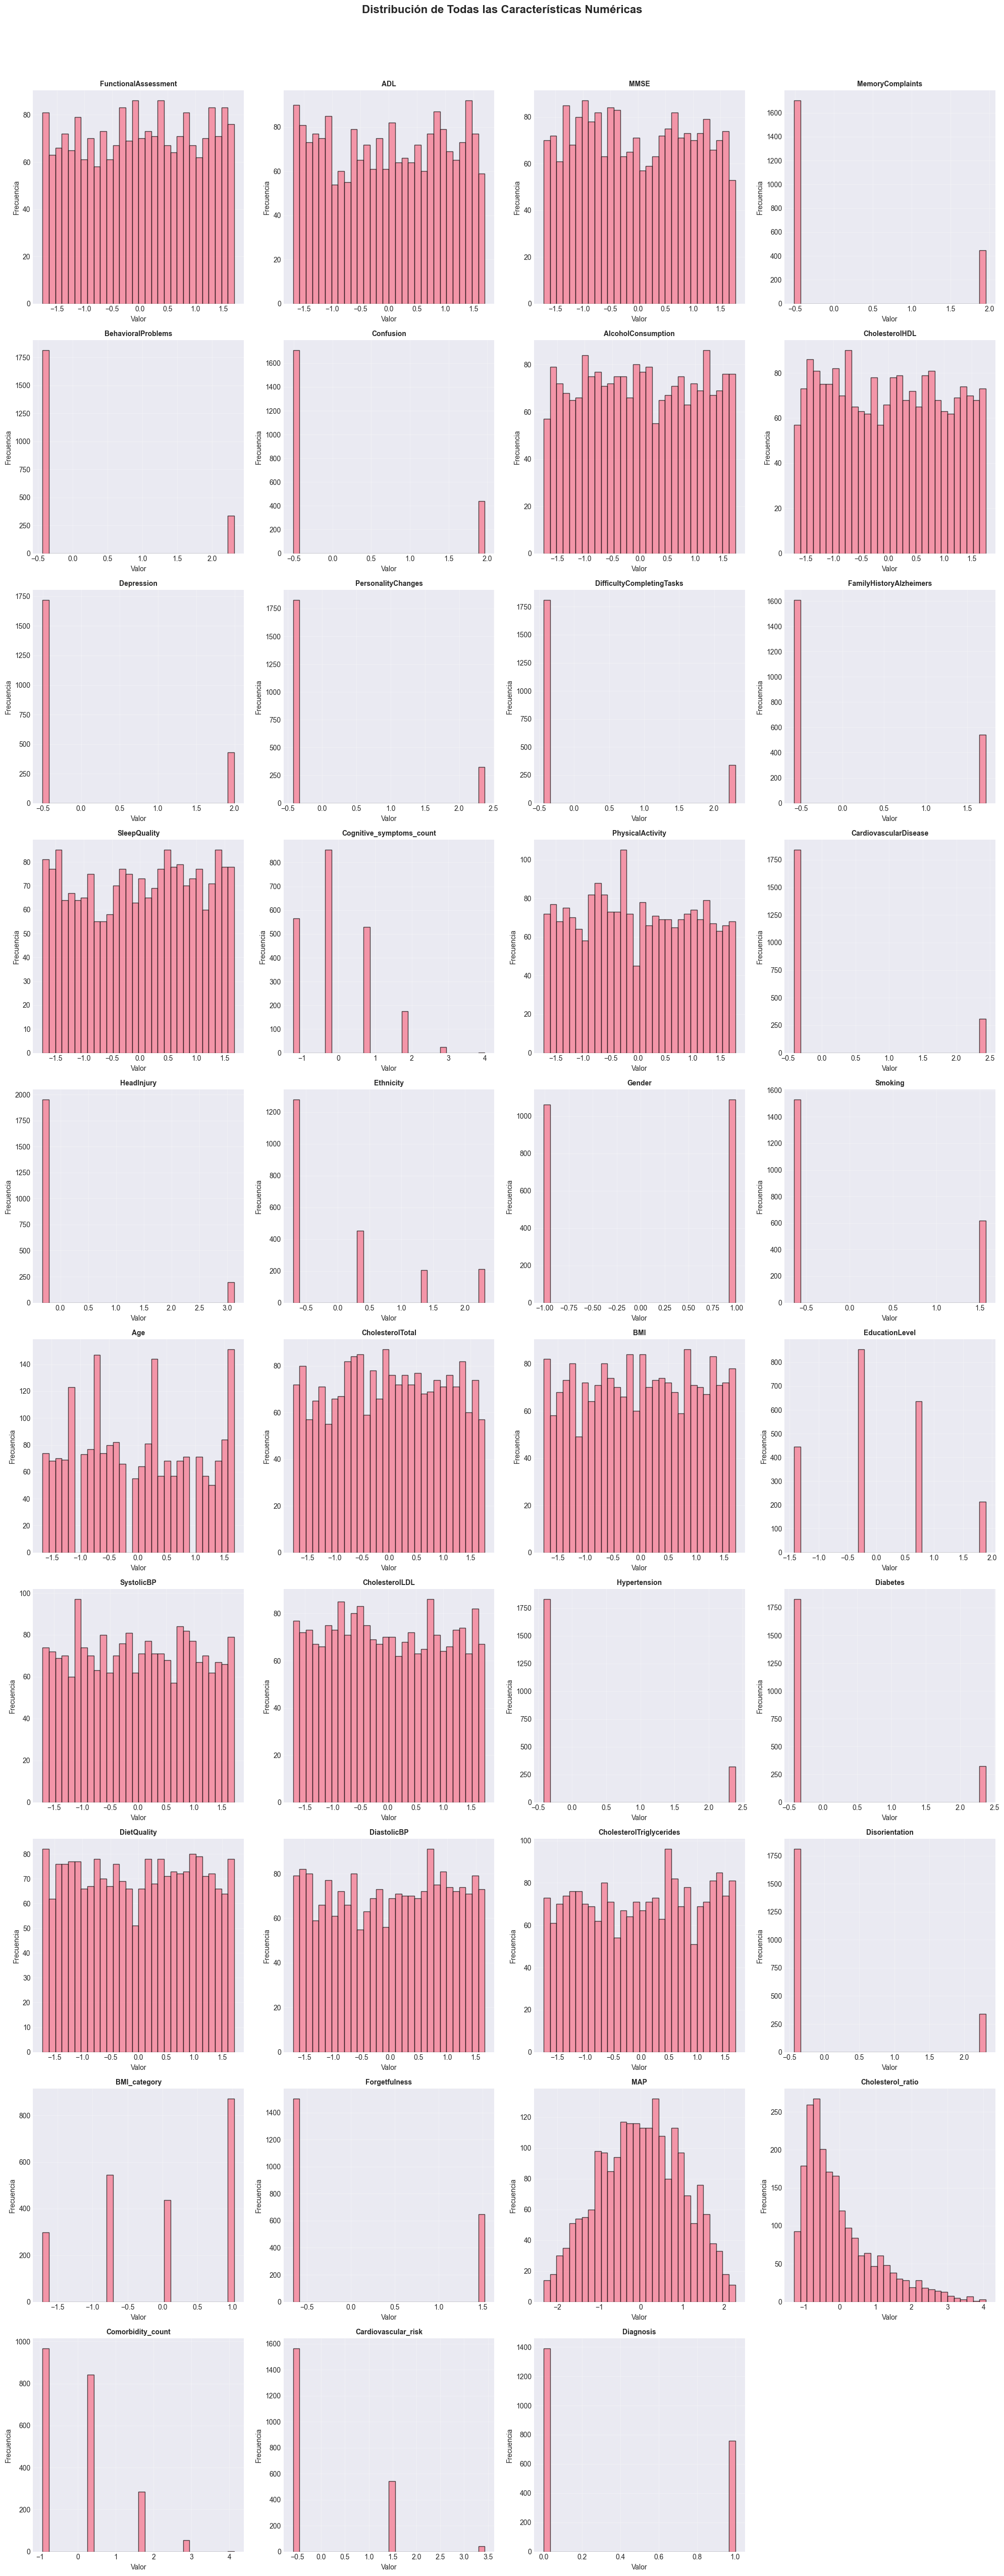

✓ Histogramas generados para 39 características numéricas


In [ ]:
# Histogramas de todas las características numéricas
print("📊 Generando histogramas de distribución para todas las características numéricas...")

# Obtener todas las columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# PatientID y DoctorInCharge ya fueron eliminados anteriormente
# No es necesario excluirlos aquí

# Calcular número de filas y columnas para la grilla
n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Crear figura con subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes.flatten()

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
        axes[idx].set_xlabel('Valor')
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(True, alpha=0.3)

# Ocultar subplots vacíos
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribución de Todas las Características Numéricas', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"✓ Histogramas generados para {len(numeric_cols)} características numéricas")


📦 Generando boxplots para detectar outliers...


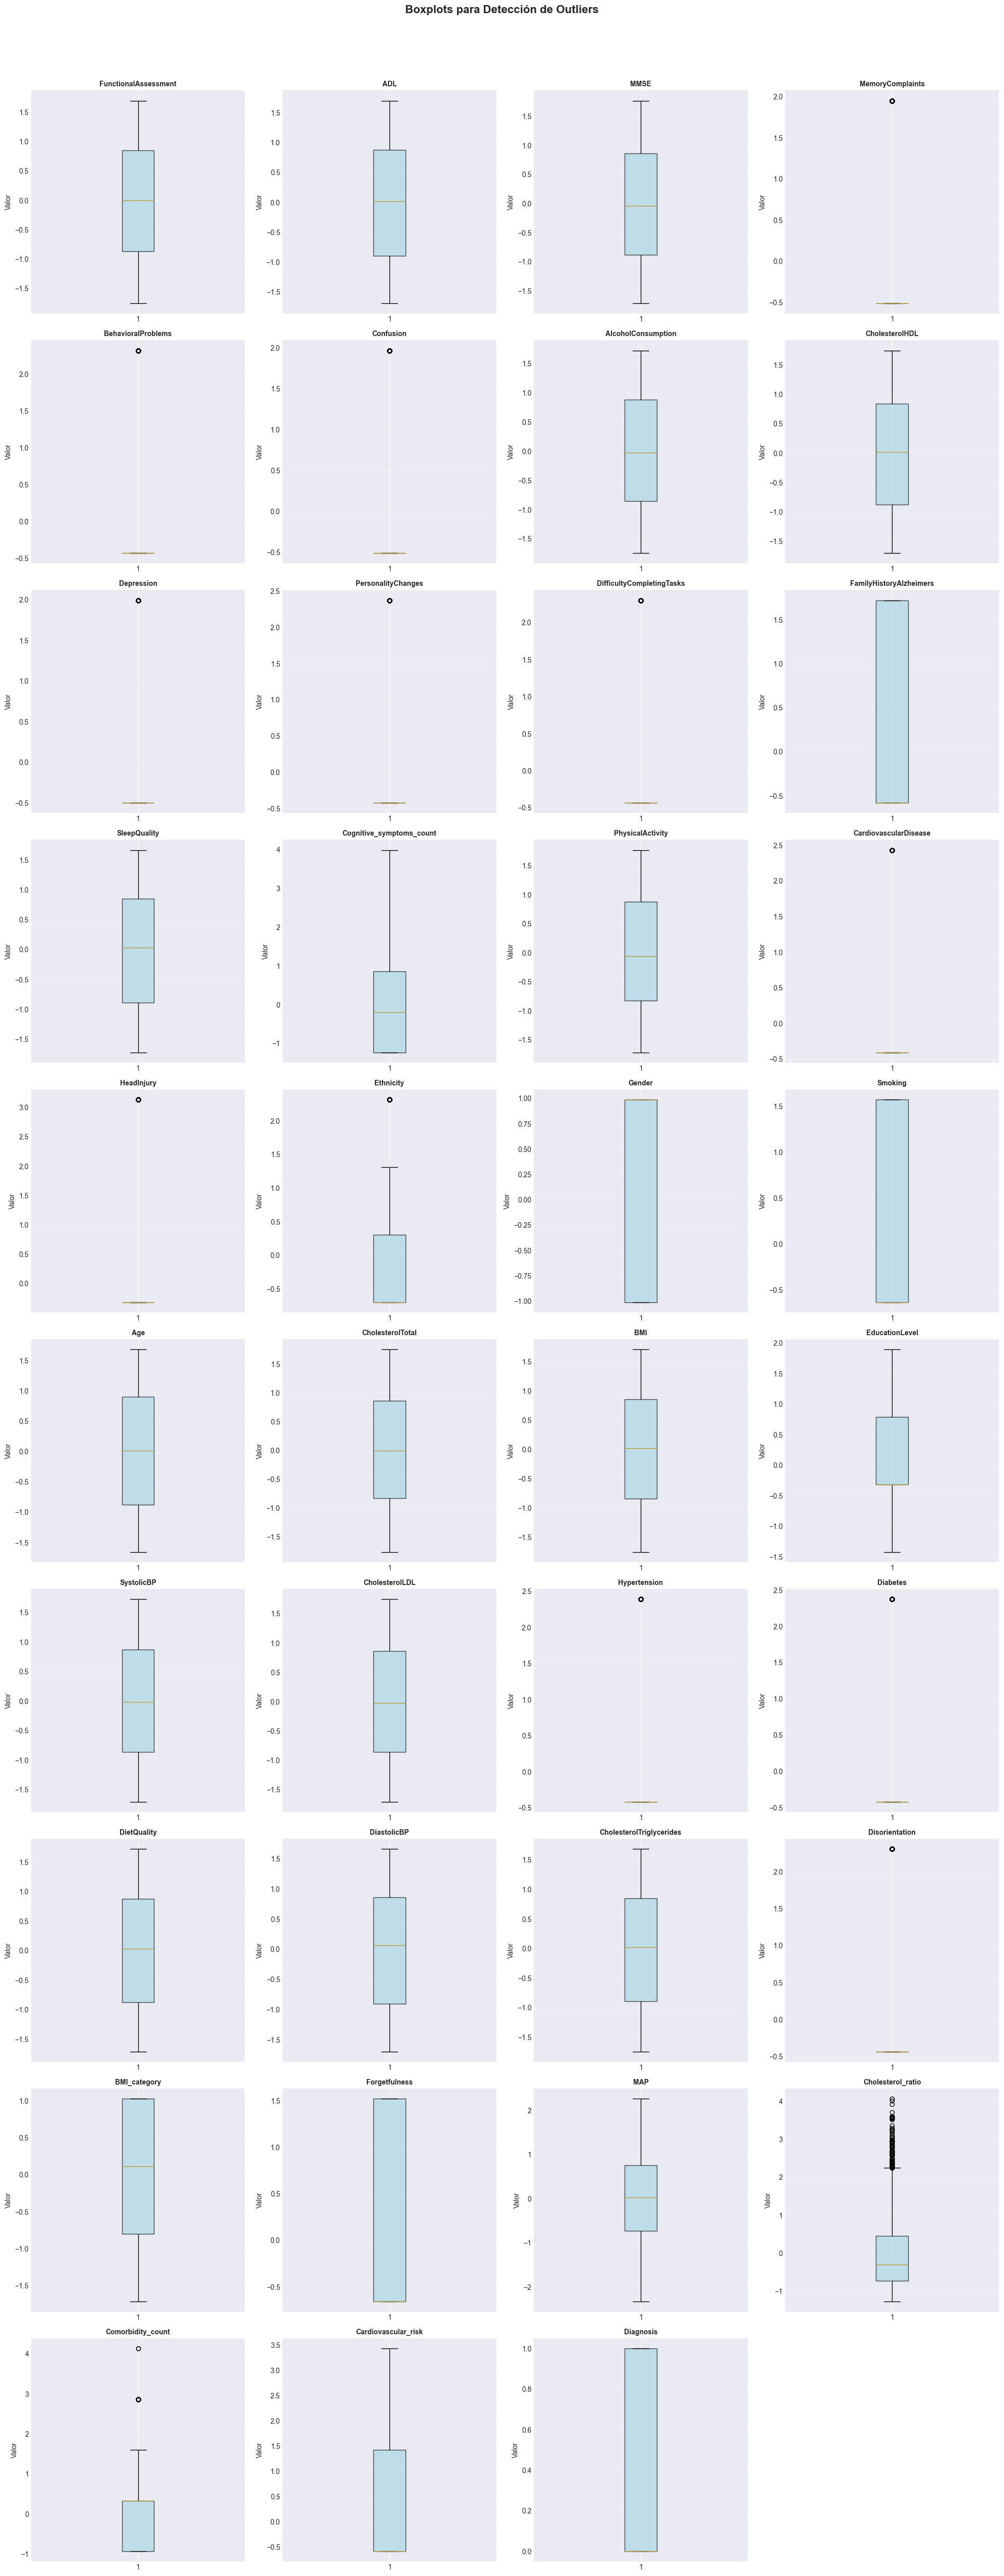

✓ Boxplots generados para 39 características numéricas


In [ ]:
# Boxplots para detectar outliers
print("📦 Generando boxplots para detectar outliers...")

# Calcular número de filas y columnas para la grilla
n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Crear figura con subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes.flatten()

for idx, col in enumerate(numeric_cols):
    if idx < len(axes):
        box_plot = axes[idx].boxplot(df[col].dropna(), vert=True, patch_artist=True)
        axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
        axes[idx].set_ylabel('Valor')
        axes[idx].grid(True, alpha=0.3, axis='y')
        
        # Colorear el boxplot
        for patch in box_plot['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)

# Ocultar subplots vacíos
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Boxplots para Detección de Outliers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"✓ Boxplots generados para {len(numeric_cols)} características numéricas")


In [ ]:
# Detectar y eliminar outliers usando el método IQR (Interquartile Range)
print("🔍 Detectando outliers usando el método IQR...")

# Configuración
REMOVE_OUTLIERS = True  # Cambiar a False si solo quieres visualizar sin eliminar
IQR_MULTIPLIER = 1.5  # Multiplicador estándar para IQR (1.5 es conservador, 3 es más estricto)

outliers_info = []
outliers_count = 0
df_before_outliers = df.copy()

# Primero, detectar y mostrar outliers sin eliminarlos
print(f"\n   Detectando outliers con IQR multiplier = {IQR_MULTIPLIER}...")

# Diccionario para almacenar outliers por fila
outliers_by_row = {}
outliers_details = []

for col in numeric_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - IQR_MULTIPLIER * IQR
        upper_bound = Q3 + IQR_MULTIPLIER * IQR
        
        # Identificar outliers
        outliers_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_indices = df[outliers_mask].index.tolist()
        n_outliers = len(outlier_indices)
        
        if n_outliers > 0:
            outliers_info.append({
                'Feature': col,
                'Outliers': n_outliers,
                'Percentage': (n_outliers / len(df)) * 100,
                'Lower Bound': lower_bound,
                'Upper Bound': upper_bound
            })
            outliers_count += n_outliers
            
            # Guardar detalles de cada outlier
            for idx in outlier_indices:
                if idx not in outliers_by_row:
                    outliers_by_row[idx] = []
                outliers_by_row[idx].append({
                    'Feature': col,
                    'Value': df.loc[idx, col],
                    'Lower Bound': lower_bound,
                    'Upper Bound': upper_bound,
                    'Type': 'Below' if df.loc[idx, col] < lower_bound else 'Above'
                })
                
                outliers_details.append({
                    'Row Index': idx,
                    'Feature': col,
                    'Value': df.loc[idx, col],
                    'Lower Bound': lower_bound,
                    'Upper Bound': upper_bound,
                    'Type': 'Below' if df.loc[idx, col] < lower_bound else 'Above'
                })

# Mostrar resumen de outliers por característica
if outliers_info:
    outliers_df = pd.DataFrame(outliers_info).sort_values('Outliers', ascending=False)
    print("\n   📊 Resumen de outliers detectados por característica:")
    print(outliers_df.to_string(index=False))
    
    # Mostrar detalles de los outliers que se van a eliminar
    print(f"\n   📋 Detalles de outliers que se van a eliminar (primeras 50 filas):")
    outliers_details_df = pd.DataFrame(outliers_details)
    
    # Agrupar por fila para mostrar todos los outliers de cada fila
    rows_to_remove = list(outliers_by_row.keys())
    print(f"\n   ⚠️  Total de filas que se eliminarán: {len(rows_to_remove)}")
    print(f"   ⚠️  Total de valores outliers detectados: {len(outliers_details)}")
    
    # Mostrar muestra de filas que se eliminarán
    if len(rows_to_remove) > 0:
        print(f"\n   📝 Muestra de filas que se eliminarán (primeras 20):")
        sample_rows = rows_to_remove[:20]
        for row_idx in sample_rows:
            row_outliers = outliers_by_row[row_idx]
            print(f"\n   Fila {row_idx}: {len(row_outliers)} outlier(s)")
            for outlier in row_outliers[:3]:  # Mostrar máximo 3 outliers por fila
                print(f"      - {outlier['Feature']}: {outlier['Value']:.4f} ({outlier['Type']} bound: {outlier['Lower Bound']:.4f} - {outlier['Upper Bound']:.4f})")
        
        if len(rows_to_remove) > 20:
            print(f"\n   ... y {len(rows_to_remove) - 20} filas más")
    
    # Visualizar outliers en gráficos
    print(f"\n   📈 Visualizando outliers en las características con más outliers...")
    top_outlier_features = outliers_df.head(6)['Feature'].tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(top_outlier_features):
        if idx < 6 and col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - IQR_MULTIPLIER * IQR
            upper_bound = Q3 + IQR_MULTIPLIER * IQR
            
            # Crear scatter plot
            axes[idx].scatter(range(len(df)), df[col], alpha=0.5, s=10, label='Datos normales')
            
            # Marcar outliers
            outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
            outlier_indices = df[outlier_mask].index
            axes[idx].scatter(outlier_indices, df.loc[outlier_indices, col], 
                            color='red', s=30, marker='x', label='Outliers', zorder=5)
            
            # Líneas de límites
            axes[idx].axhline(y=lower_bound, color='orange', linestyle='--', linewidth=2, label='Límite inferior')
            axes[idx].axhline(y=upper_bound, color='orange', linestyle='--', linewidth=2, label='Límite superior')
            
            axes[idx].set_title(f'{col}\n({outlier_mask.sum()} outliers)', fontsize=10, fontweight='bold')
            axes[idx].set_xlabel('Índice de Fila')
            axes[idx].set_ylabel('Valor')
            axes[idx].legend(fontsize=8)
            axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle('Visualización de Outliers que se Eliminarán', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Ahora eliminar si está habilitado
    if REMOVE_OUTLIERS:
        print(f"\n   🗑️  Eliminando {len(rows_to_remove)} filas con outliers...")
        df = df.drop(index=rows_to_remove)
        n_rows_removed = len(rows_to_remove)
        n_rows_before = len(df_before_outliers)
        
        print(f"   ✓ Eliminadas {n_rows_removed} filas con outliers ({n_rows_removed/n_rows_before*100:.2f}% del dataset)")
        print(f"   ✓ Dataset después de eliminar outliers: {df.shape}")
    else:
        print(f"\n   ⚠️  Modo de solo visualización activado (REMOVE_OUTLIERS = False)")
        print(f"   Para eliminar outliers, cambia REMOVE_OUTLIERS = True")
        print(f"   Se eliminarían {len(rows_to_remove)} filas si REMOVE_OUTLIERS = True")
else:
    print("   ✓ No se detectaron outliers significativos")


🔍 Detectando outliers usando el método IQR...
   ⚠️  Modo de solo visualización activado (REMOVE_OUTLIERS = False)
   Para eliminar outliers, cambia REMOVE_OUTLIERS = True


In [ ]:
# Visualización comparativa: antes y después de eliminar outliers (para algunas características clave)
if REMOVE_OUTLIERS and outliers_info:
    print("\n📊 Comparación antes/después de eliminar outliers (características con más outliers):")
    
    # Seleccionar top 6 características con más outliers
    top_outlier_features = pd.DataFrame(outliers_info).nlargest(6, 'Outliers')['Feature'].tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(top_outlier_features):
        if idx < 6 and col in df_before_outliers.columns:
            # Boxplot antes
            axes[idx].boxplot(df_before_outliers[col].dropna(), vert=True, patch_artist=True)
            axes[idx].set_title(f'{col}\n(Antes: {len(df_before_outliers)} filas)', 
                               fontsize=10, fontweight='bold')
            axes[idx].set_ylabel('Valor')
            axes[idx].grid(True, alpha=0.3, axis='y')
            
            # Colorear
            for patch in axes[idx].patches:
                patch.set_facecolor('lightcoral')
                patch.set_alpha(0.7)
    
    plt.suptitle('Boxplots ANTES de Eliminar Outliers', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, col in enumerate(top_outlier_features):
        if idx < 6 and col in df.columns:
            # Boxplot después
            axes[idx].boxplot(df[col].dropna(), vert=True, patch_artist=True)
            axes[idx].set_title(f'{col}\n(Después: {len(df)} filas)', 
                               fontsize=10, fontweight='bold')
            axes[idx].set_ylabel('Valor')
            axes[idx].grid(True, alpha=0.3, axis='y')
            
            # Colorear
            for patch in axes[idx].patches:
                patch.set_facecolor('lightgreen')
                patch.set_alpha(0.7)
    
    plt.suptitle('Boxplots DESPUÉS de Eliminar Outliers', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Comparación visual completada")


## 6. Escalamiento de Características


In [ ]:
# Configuración
TARGET_COL = 'Diagnosis'
exclude_from_scaling = ['PatientID', TARGET_COL, 'DoctorInCharge']
exclude_from_scaling = [col for col in exclude_from_scaling if col in df.columns]

# Identificar columnas numéricas a escalar
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_scale = [col for col in numeric_cols if col not in exclude_from_scaling]

if not cols_to_scale:
    print("⚠️  No hay columnas numéricas para escalar")
    scaler = None
else:
    print(f"\n🔄 Escalando {len(cols_to_scale)} características numéricas...")
    
    scaler = StandardScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    
    print("✓ Escalamiento completado")
    print(f"  Columnas escaladas: {len(cols_to_scale)}")
    print(f"  Columnas excluidas: {exclude_from_scaling}")



🔄 Escalando 38 características numéricas...
✓ Escalamiento completado
  Columnas escaladas: 38
  Columnas excluidas: ['PatientID', 'Diagnosis']


## 7. Selección de Características



   Visualizando matriz de correlación...


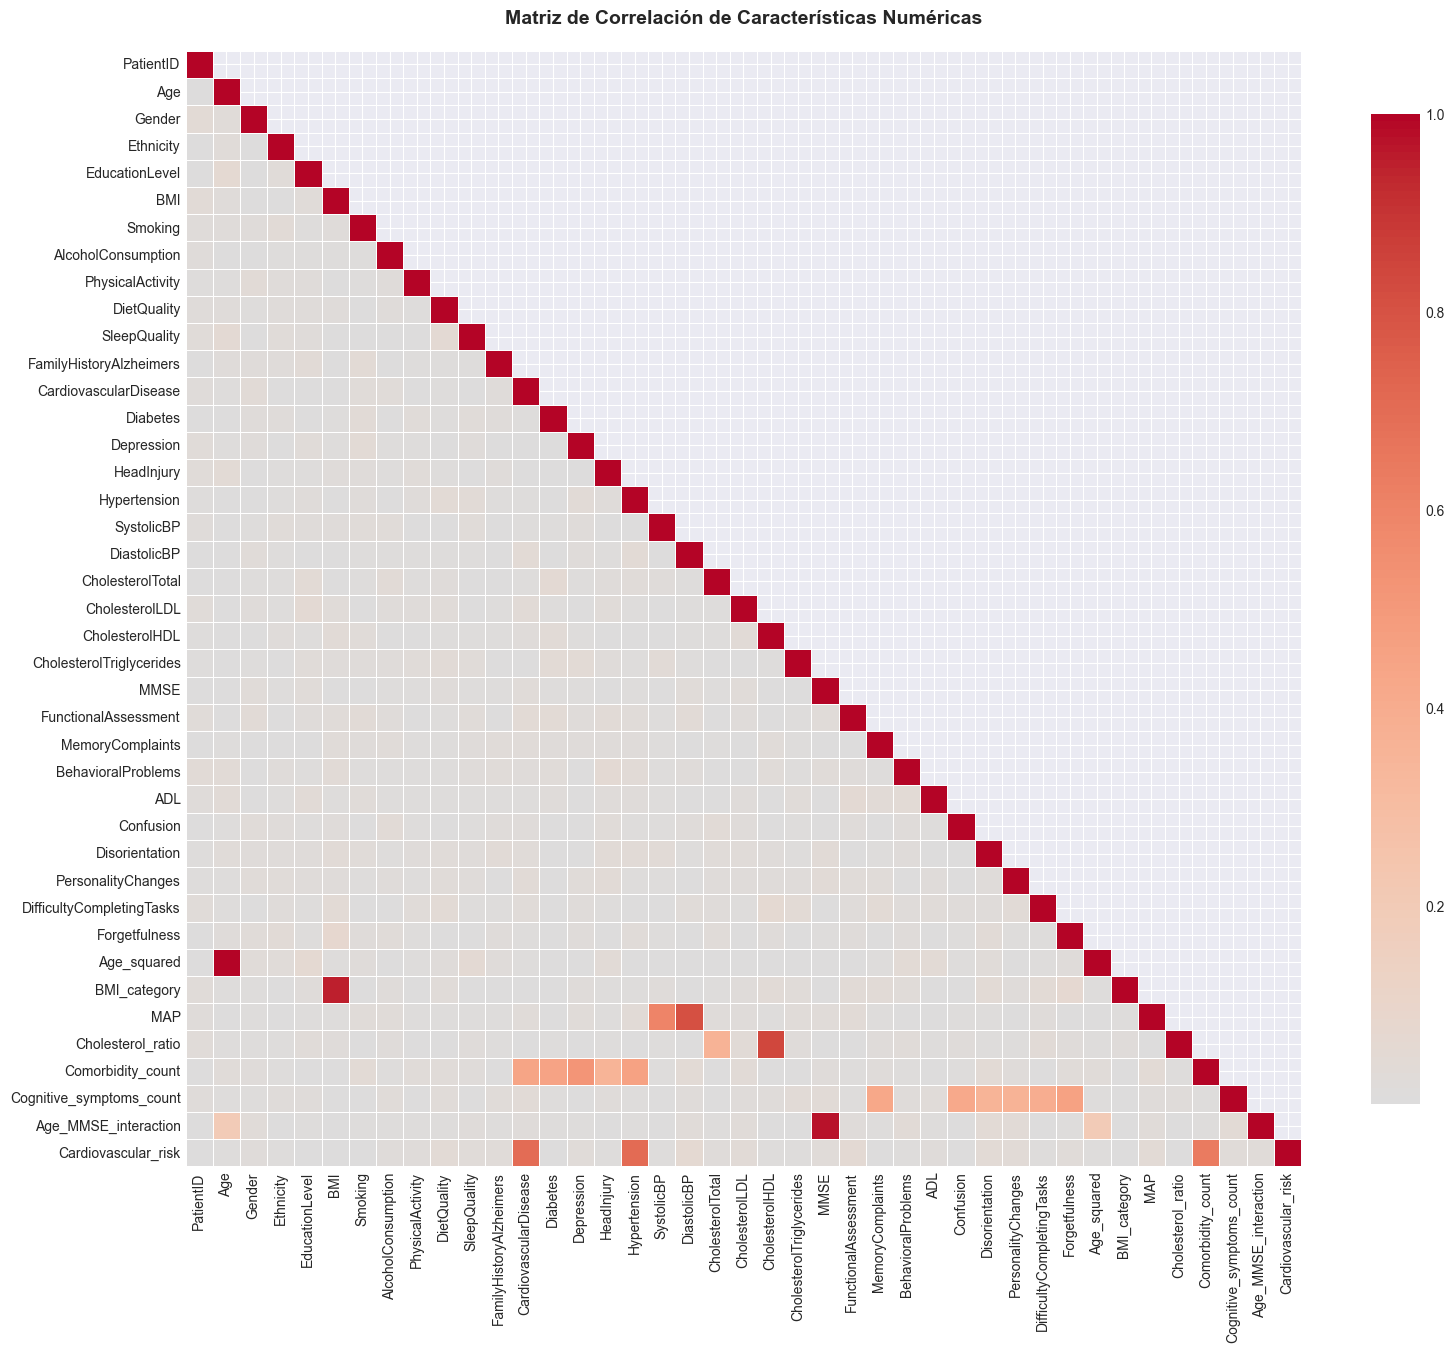


   Pares de características con alta correlación (>0.7):
     Feature 1            Feature 2  Correlation
           Age          Age_squared     0.998556
          MMSE Age_MMSE_interaction     0.972442
           BMI         BMI_category     0.948932
CholesterolHDL    Cholesterol_ratio     0.840851
   DiastolicBP                  MAP     0.805340
  Hypertension  Cardiovascular_risk     0.707652

🔍 Realizando selección de características...
   Características iniciales: 39

   Paso 1: Eliminando características altamente correlacionadas...

   Paso 2: Calculando Mutual Information...
   ✓ Top 39 características seleccionadas por Mutual Information

   Top 10 características por Mutual Information:
                     feature  mi_score
0       FunctionalAssessment  0.095454
1                        ADL  0.076564
2                       MMSE  0.066278
3           MemoryComplaints  0.062866
9                  PatientID  0.018241
6         AlcoholConsumption  0.017780
14  Cognitive_symp

In [ ]:
# Configuración
APPLY_FEATURE_SELECTION = True
TOP_K_FEATURES = 50
TASK_TYPE = 'classification' 
CORRELATION_THRESHOLD = 0.95

# Visualizar matriz de correlación con heatmap
if APPLY_FEATURE_SELECTION:
    print("\n   Visualizando matriz de correlación...")
    
    # Crear figura más grande para mejor visualización
    plt.figure(figsize=(16, 14))
    
    # Crear heatmap de correlación
    # Si hay muchas características, mostrar solo las más importantes
    if corr_matrix.shape[0] > 30:
        # Seleccionar características con mayor varianza o importancia
        # Por ahora, mostrar todas pero con tamaño de fuente más pequeño
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Máscara para triángulo superior
        sns.heatmap(
            corr_matrix,
            mask=mask,
            annot=False,  # No mostrar valores si hay muchas características
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            fmt='.2f'
        )
    else:
        # Si hay pocas características, mostrar valores
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
        sns.heatmap(
            corr_matrix,
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            fmt='.2f',
            annot_kws={'size': 8}
        )
    
    plt.title('Matriz de Correlación de Características Numéricas', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Mostrar pares de características con alta correlación
    print("\n   Pares de características con alta correlación (>0.7):")
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > 0.7:
                high_corr_pairs.append({
                    'Feature 1': corr_matrix.columns[i],
                    'Feature 2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })
    
    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
        print(high_corr_df.to_string(index=False))
    else:
        print("     No se encontraron pares con correlación > 0.7")


if APPLY_FEATURE_SELECTION:
    # Separar características y objetivo
    X = df.drop(columns=[TARGET_COL])
    y = df[TARGET_COL]
    
    # Solo numéricas para análisis
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    X_numeric = X[numeric_cols]
    
    print(f"\n🔍 Realizando selección de características...")
    print(f"   Características iniciales: {X_numeric.shape[1]}")
    
    # 1. Eliminar características altamente correlacionadas
    print("\n   Paso 1: Eliminando características altamente correlacionadas...")
    corr_matrix = X_numeric.corr().abs()
    upper_triangle = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    )
    
    high_corr_cols = [
        column for column in upper_triangle.columns 
        if any(upper_triangle[column] > CORRELATION_THRESHOLD)
    ]
    
    if high_corr_cols:
        print(f"     Eliminando {len(high_corr_cols)} características con correlación > {CORRELATION_THRESHOLD}")
        X_numeric = X_numeric.drop(columns=high_corr_cols)
    
    # 2. Mutual Information
    print("\n   Paso 2: Calculando Mutual Information...")
    if TASK_TYPE == 'classification':
        mi_scores = mutual_info_classif(X_numeric, y, random_state=42)
    else:
        mi_scores = mutual_info_regression(X_numeric, y, random_state=42)
    
    mi_df = pd.DataFrame({
        'feature': X_numeric.columns,
        'mi_score': mi_scores
    }).sort_values('mi_score', ascending=False)
    
    # Seleccionar top k
    top_features = mi_df.head(min(TOP_K_FEATURES, len(mi_df)))['feature'].tolist()
    
    print(f"   ✓ Top {len(top_features)} características seleccionadas por Mutual Information")
    
    # Mostrar top 10 características
    print("\n   Top 10 características por Mutual Information:")
    print(mi_df.head(10))
    
    # Combinar con características no numéricas (si las hay)
    non_numeric_cols = [col for col in X.columns if col not in numeric_cols]
    selected_cols = top_features + non_numeric_cols + [TARGET_COL]
    
    df = df[selected_cols]
    
    print(f"\n   Características finales: {df.shape[1] - 1} (sin contar objetivo)")
else:
    print("⚠️  Selección de características deshabilitada")
    top_features = None


## 8. Guardado de Datos Procesados


In [ ]:
# Guardar datos procesados
df.to_csv(OUTPUT_PATH, index=False)

print(f"\n✅ Preprocesamiento completado!")
print(f"   Datos guardados en: {OUTPUT_PATH}")
print(f"   Dimensiones finales: {df.shape}")

# Guardar información del preprocesamiento
info_path = PROCESSED_DIR / 'preprocessing_info.txt'
with open(info_path, 'w', encoding='utf-8') as f:
    f.write("INFORMACIÓN DE PREPROCESAMIENTO\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Método de imputación: {IMPUTATION_METHOD}\n")
    f.write(f"Características creadas: {len(new_features)}\n")
    if new_features:
        f.write(f"  - {', '.join(new_features)}\n")
    if APPLY_FEATURE_SELECTION and top_features:
        f.write(f"\nCaracterísticas seleccionadas: {len(top_features)}\n")
    f.write(f"\nDimensiones finales: {df.shape}\n")

print(f"   Información guardada en: {info_path}")


## 9. Resumen Final


In [ ]:
print("=" * 60)
print("RESUMEN DEL PREPROCESAMIENTO")
print("=" * 60)
print(f"Filas: {df.shape[0]}")
print(f"Columnas: {df.shape[1]}")
print(f"\nPrimeras columnas: {list(df.columns[:10])}")
print(f"\nÚltimas columnas: {list(df.columns[-10:])}")

# Verificar distribución de la variable objetivo
if TARGET_COL in df.columns:
    print(f"\nDistribución de {TARGET_COL}:")
    print(df[TARGET_COL].value_counts())
    print(f"\nProporciones:")
    print(df[TARGET_COL].value_counts(normalize=True))


In [ ]:
# Visualización de las primeras filas del dataset procesado
df.head(10)


In [ ]:
# Estadísticas descriptivas
df.describe()
